# Hurricane Activity Forecasting: Monthly

In [102]:
import pandas as pd
import numpy as np
from time import process_time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn model pipelining and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# sklearn models
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge

In [10]:
hurdat = pd.read_csv('data/hurdat_cleaned.csv').drop(['Unnamed: 0'],axis=1).query('year >= 1950 & max_wind >= 35.0').reset_index()
hurdat = hurdat[['year','name','date','time','status','latitude','longitude','max_wind','min_pressure']]
hurdat.head()

,year,name,date,time,status,latitude,longitude,max_wind,min_pressure
0,1950,ABLE,1950-08-12,0,TS,17.1N,55.5W,35.0,-999.0
1,1950,ABLE,1950-08-12,600,TS,17.7N,56.3W,40.0,-999.0
2,1950,ABLE,1950-08-12,1200,TS,18.2N,57.4W,45.0,-999.0
3,1950,ABLE,1950-08-12,1800,TS,19.0N,58.6W,50.0,-999.0
4,1950,ABLE,1950-08-13,0,TS,20.0N,60.0W,50.0,-999.0


In [40]:
# Group by [year, name] and get the index of the row with the maximum max_wind
idx = hurdat.groupby(['year', 'name'])['max_wind'].idxmax()

# Filter the original DataFrame using these indices
hurdat_maxwind = hurdat.loc[idx].reset_index(drop=True)
hurdat_maxwind.head()

,year,name,date,time,status,latitude,longitude,max_wind,min_pressure
0,1950,ABLE,1950-08-19,1800,HU,31.7N,75.5W,110.0,-999.0
1,1950,BAKER,1950-08-30,0,HU,24.7N,88.6W,90.0,-999.0
2,1950,CHARLIE,1950-08-31,1200,HU,32.8N,56.7W,95.0,-999.0
3,1950,DOG,1950-09-05,1200,HU,24.6N,67.7W,125.0,-999.0
4,1950,EASY,1950-09-05,600,HU,28.5N,83.3W,105.0,-999.0


In [14]:
duplicates = hurdat_maxwind[hurdat_maxwind.duplicated(subset=['year', 'name'], keep=False)]
duplicates

,year,name,date,time,status,latitude,longitude,max_wind,min_pressure


In [54]:
hurdat_maxwind['month'] = pd.to_datetime(hurdat_maxwind['date'],format = '%Y-%m-%d').dt.month

nstorms_bymonth = hurdat_maxwind.groupby(['year','month']).size().reset_index(name='nstorms')
nstorms_bymonth.head()

,year,month,nstorms
0,1950,8,3
1,1950,9,3
2,1950,10,8
3,1951,5,1
4,1951,8,2


In [55]:
# Create a complete index of all year-month combinations from 1950 to 2022
years = range(1950, 2023)
months = range(1, 13)
complete_index = pd.MultiIndex.from_product([years, months], names=['year', 'month'])

# Reindex your dataframe to include all year-month combinations
nstorms_bymonth = nstorms_bymonth.set_index(['year', 'month']).reindex(complete_index, fill_value=0).reset_index()
nstorms_bymonth.head()

,year,month,nstorms
0,1950,1,0
1,1950,2,0
2,1950,3,0
3,1950,4,0
4,1950,5,0


In [49]:
midgulf = pd.read_csv('data/1975to2023_MidGulf_buoydata.csv').drop(['Unnamed: 0','DD','hh','MWD','DEWP','VIS'], axis=1).rename(columns={'MM':'month','YY':'year'})
midgulf = midgulf.sort_values(by=['year','month'])
midgulf.head()

,year,month,WDIR,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP
532,1975,8,106.175439,3.609302,NaN,NaN,NaN,NaN,1069.461850,29.108235,29.527778
533,1975,9,123.327354,7.677876,NaN,NaN,NaN,NaN,1052.850220,26.243304,27.649282
534,1975,10,116.771739,6.147464,NaN,NaN,NaN,NaN,1047.720863,24.326909,25.648352
535,1975,11,145.370968,7.026506,NaN,NaN,NaN,NaN,1050.880876,24.772984,26.200000
522,1976,1,281.062500,3.987097,NaN,0.53125,NaN,3.875,1300.687500,17.680645,20.974194


In [37]:
oni = pd.read_csv('data/Monthly_Nino_3.4_Index.csv').drop(['Unnamed: 0','ONI_climAdjust'],axis=1)
oni.head()

,year,month,ONI_total,ONI_anom
0,1950,5,26.19,-1.37
1,1950,6,26.47,-0.74
2,1950,7,26.28,-0.44
3,1950,8,25.88,-0.42
4,1950,9,25.73,-0.41


In [73]:
pd.merge(nstorms_bymonth, oni, on = ['year','month'], how = 'outer').dropna()

,year,month,nstorms,ONI_total,ONI_anom
4,1950,5,0.0,26.19,-1.37
5,1950,6,0.0,26.47,-0.74
6,1950,7,0.0,26.28,-0.44
7,1950,8,3.0,25.88,-0.42
8,1950,9,3.0,25.73,-0.41
...,...,...,...,...,...
871,2022,8,0.0,25.88,-0.97
872,2022,9,6.0,25.65,-1.07
873,2022,10,2.0,25.73,-0.99
874,2022,11,3.0,25.80,-0.90


In [76]:
df = pd.merge(nstorms_bymonth, oni, on = ['year','month'], how = 'outer').dropna()
df = pd.merge(df, midgulf, on = ['year','month'], how = 'inner').dropna().reset_index(drop=True)
print(df.size)
X = df.drop(['year','month','nstorms'],axis=1)
y = df['nstorms']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
df.head()

6090


,year,month,nstorms,ONI_total,ONI_anom,WDIR,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP
0,1979,12,0.0,27.11,0.69,134.597504,6.732558,8.530698,1.230698,6.060465,4.674729,1088.254714,22.492570,25.630078
1,1980,1,0.0,27.09,0.70,157.370968,7.508428,9.345330,1.272274,5.996885,4.540966,3584.867233,21.951534,24.956033
2,1980,2,0.0,26.98,0.39,126.303887,7.568182,9.902797,1.520979,6.436014,4.904196,1020.269231,18.394406,23.861189
3,1980,4,0.0,27.76,0.34,179.579528,6.303297,7.787284,1.227943,6.143485,4.878964,1015.237677,22.135322,23.512559
4,1980,5,0.0,28.02,0.51,138.636119,5.668414,6.839113,0.920699,5.694892,4.516667,1012.922849,25.641667,25.988844


In [90]:
def run_grid(model_setup, N_JOBS = 1, N_CV = 5):
    start = process_time()
    # Make Pipeline
    pipe = Pipeline([
        #('preprocessor',preprocessor),
        ('poly', PolynomialFeatures(degree = 3)),
        ('scaler',StandardScaler()),
        (model_setup.get('name'), model_setup.get('model'))
        ])

    # Fit Grid on all params
    grid = GridSearchCV(estimator = pipe,
                        param_grid = model_setup.get('param_dict'),
                       cv = N_CV,
                       n_jobs = N_JOBS)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_train_preds = best_model.predict(X_train)
    y_test_preds = best_model.predict(X_test)

    # Save stuff to a dataframe (best params, fit time, scores)
    res_dict = {'model': [model_setup.get('name')],
                'best_params': [grid.best_params_],
                'best_score': [grid.best_score_],
                'fit time': [grid.refit_time_],
               'train r2': [grid.score(X_train, y_train)],
               'test r2': [grid.score(X_test, y_test)],
                'train mse': [mean_squared_error(y_train, y_train_preds)],
                'test mse': [mean_squared_error(y_test, y_test_preds)]
               }
    res_df = pd.DataFrame(res_dict)

    feature_names = best_model.named_steps['poly'].get_feature_names_out()
    coefs = best_model.named_steps[model_setup.get('name')].coef_
    coef_df = pd.DataFrame({'feature':feature_names, 'coef':coefs})

    end = process_time()
    print('total time to run: ',end - start)
    
    return(res_df, best_model, coef_df)

In [97]:
model_setup_linreg = {
    'name':'linreg',
    'param_dict':{},
    'model': LinearRegression()
}
results_linreg, _, coefs_linreg = run_grid(model_setup_linreg, N_JOBS = 2)
results_linreg

total time to run:  1.9612000000000052


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,linreg,{},-6860.599928,0.27927,1.0,-1622.742563,4.011590e-21,4449.32523


In [96]:
model_setup_lasso = {
    'name':'lasso',
    'param_dict':{'lasso__alpha':[0.001,0.01,0.1,1,10,100,1000],'lasso__max_iter':[10000]},
    'model': Lasso()
}
results_lasso, _, coefs_lasso = run_grid(model_setup_lasso, N_JOBS = 2)
results_lasso

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.284e+00, tolerance: 6.535e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.600e+00, tolerance: 6.936e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.443e+00, toler

total time to run:  2.0180679999999995


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,lasso,"{'lasso__alpha': 0.01, 'lasso__max_iter': 10000}",0.535732,0.270201,0.596538,0.458808,1.123381,1.482957


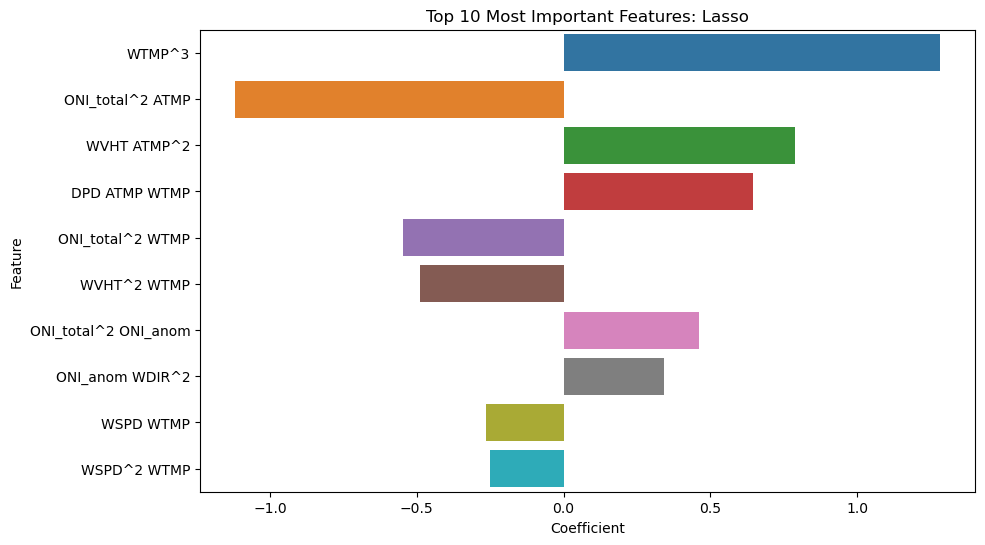

In [106]:
coefs_lasso_top10 = coefs_lasso.sort_values(by = 'coef', ascending = False, key = abs).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='coef', y='feature', data=coefs_lasso_top10)
plt.title('Top 10 Most Important Features: Lasso')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

In [92]:
model_setup_ridge = {
    'name':'ridge',
    'param_dict':{'ridge__alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000]},
    'model': Ridge()
}
results_ridge, _, coefs_ridge = run_grid(model_setup_ridge, N_JOBS = 2)
results_ridge

total time to run:  0.294986999999999


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,ridge,{'ridge__alpha': 10},0.519924,0.014228,0.614185,0.451861,1.074245,1.501991


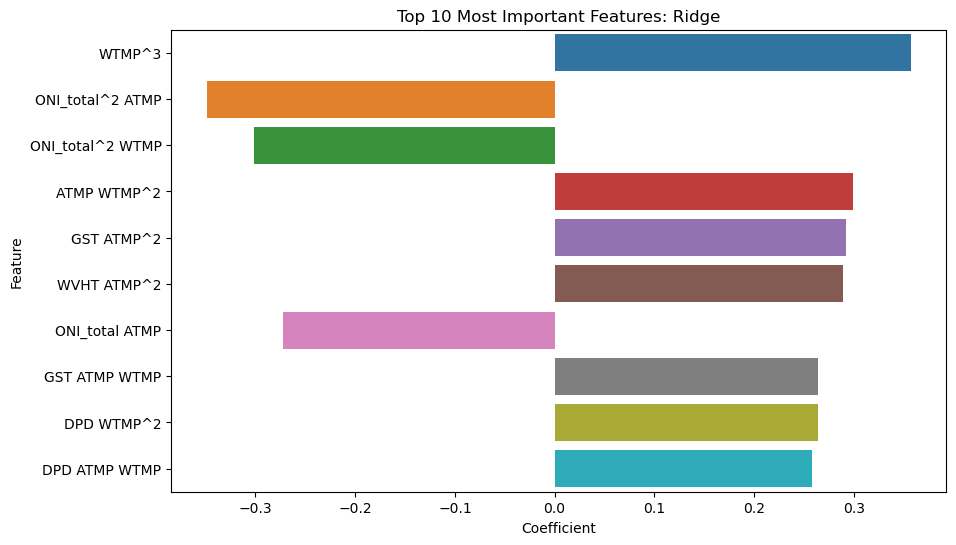

In [105]:
coefs_ridge_top10 = coefs_ridge.sort_values(by = 'coef', ascending = False, key = abs).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='coef', y='feature', data=coefs_ridge_top10)
plt.title('Top 10 Most Important Features: Ridge')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

About ONI_total: Oceanic Nino Index is an indicator of teh El Nino-Southern Oscillation (ENSO). El Nino events (positive ONI) "generally suppress Atlantic hurricane acivity", so it is encouraging to see a negative coefficient for ONI_total occur multiple times on this plot. This suggests ONI_total can be an important feature in hurricane forecasting.

# Results
### Oceanic Nino Index (ONI)
About ONI_total: Oceanic Nino Index is an indicator of teh El Nino-Southern Oscillation (ENSO). El Nino events (positive ONI) "generally suppress Atlantic hurricane acivity", so it is encouraging to see a negative coefficient for ONI_total occur multiple times on this plot. This suggests ONI_total can be an important feature in hurricane forecasting.

### Water Temperature (WTMP)
Hurricanes are driven in part by warm sea surface temperatures, captured at the Mid Gulf buoy as "WTMP" or "Water Temperature". It makes sense to see a strong positive coefficient for WTMP^3, as this variable ought to be correlated with increased hurricane activity.

### Atmospheric Pressure (ATMP)
Another value captured by NOAA/NDBC buoys, this is another feature that shows prominently in the most important features. I don't have a strong meteorological argument for the importance of ATMP here, so I will need to do more research to better understand this.